In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
import csv
from sklearn.model_selection import GridSearchCV
import tqdm

In [4]:
df = pd.read_csv("/content/AmesHousing.tsv", sep="\t")
df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


In [5]:
def transform_features(df):

    feature_data = {"Feature": df.isnull().sum().keys().tolist(), "Missing Values": df.isnull().sum().values.tolist()}
    df_features = pd.DataFrame(feature_data)
    rows,cols = df.shape
    df_features['Percent Missing'] = 100*df_features['Missing Values']/rows
    features = df_features[df_features['Percent Missing'] > 5]['Feature'].tolist()
    df = df.drop(features, axis=1)

    text_feature_data = {"Feature": df.select_dtypes(include=['object']).isnull().sum().keys().tolist(), "Missing Values": df.select_dtypes(include=['object']).isnull().sum().values.tolist()}
    df_text_features = pd.DataFrame(text_feature_data)
    text_features = df_text_features[df_text_features['Missing Values'] > 0]['Feature'].tolist()
    df = df.drop(text_features, axis=1)

    numeric_dtypes_missing_values = df.select_dtypes(include=['int64','float64']).isnull().sum()
    numeric_features = numeric_dtypes_missing_values[numeric_dtypes_missing_values > 0]
    df = df.fillna(value=numeric_features)

    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df = df.drop(['Year Built', 'Year Remod/Add'], axis=1)
    df = df.drop([1702,2180,2181], axis=0)
    df = df.drop(["Order","PID","Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

    return df


def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = transform_df.select_dtypes(include=['int64', 'float64'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)

    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood",
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st",
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type",
                    "Misc Feature", "Sale Type", "Sale Condition"]

    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)

    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)

    return df

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
print(len(filtered_df))

2927


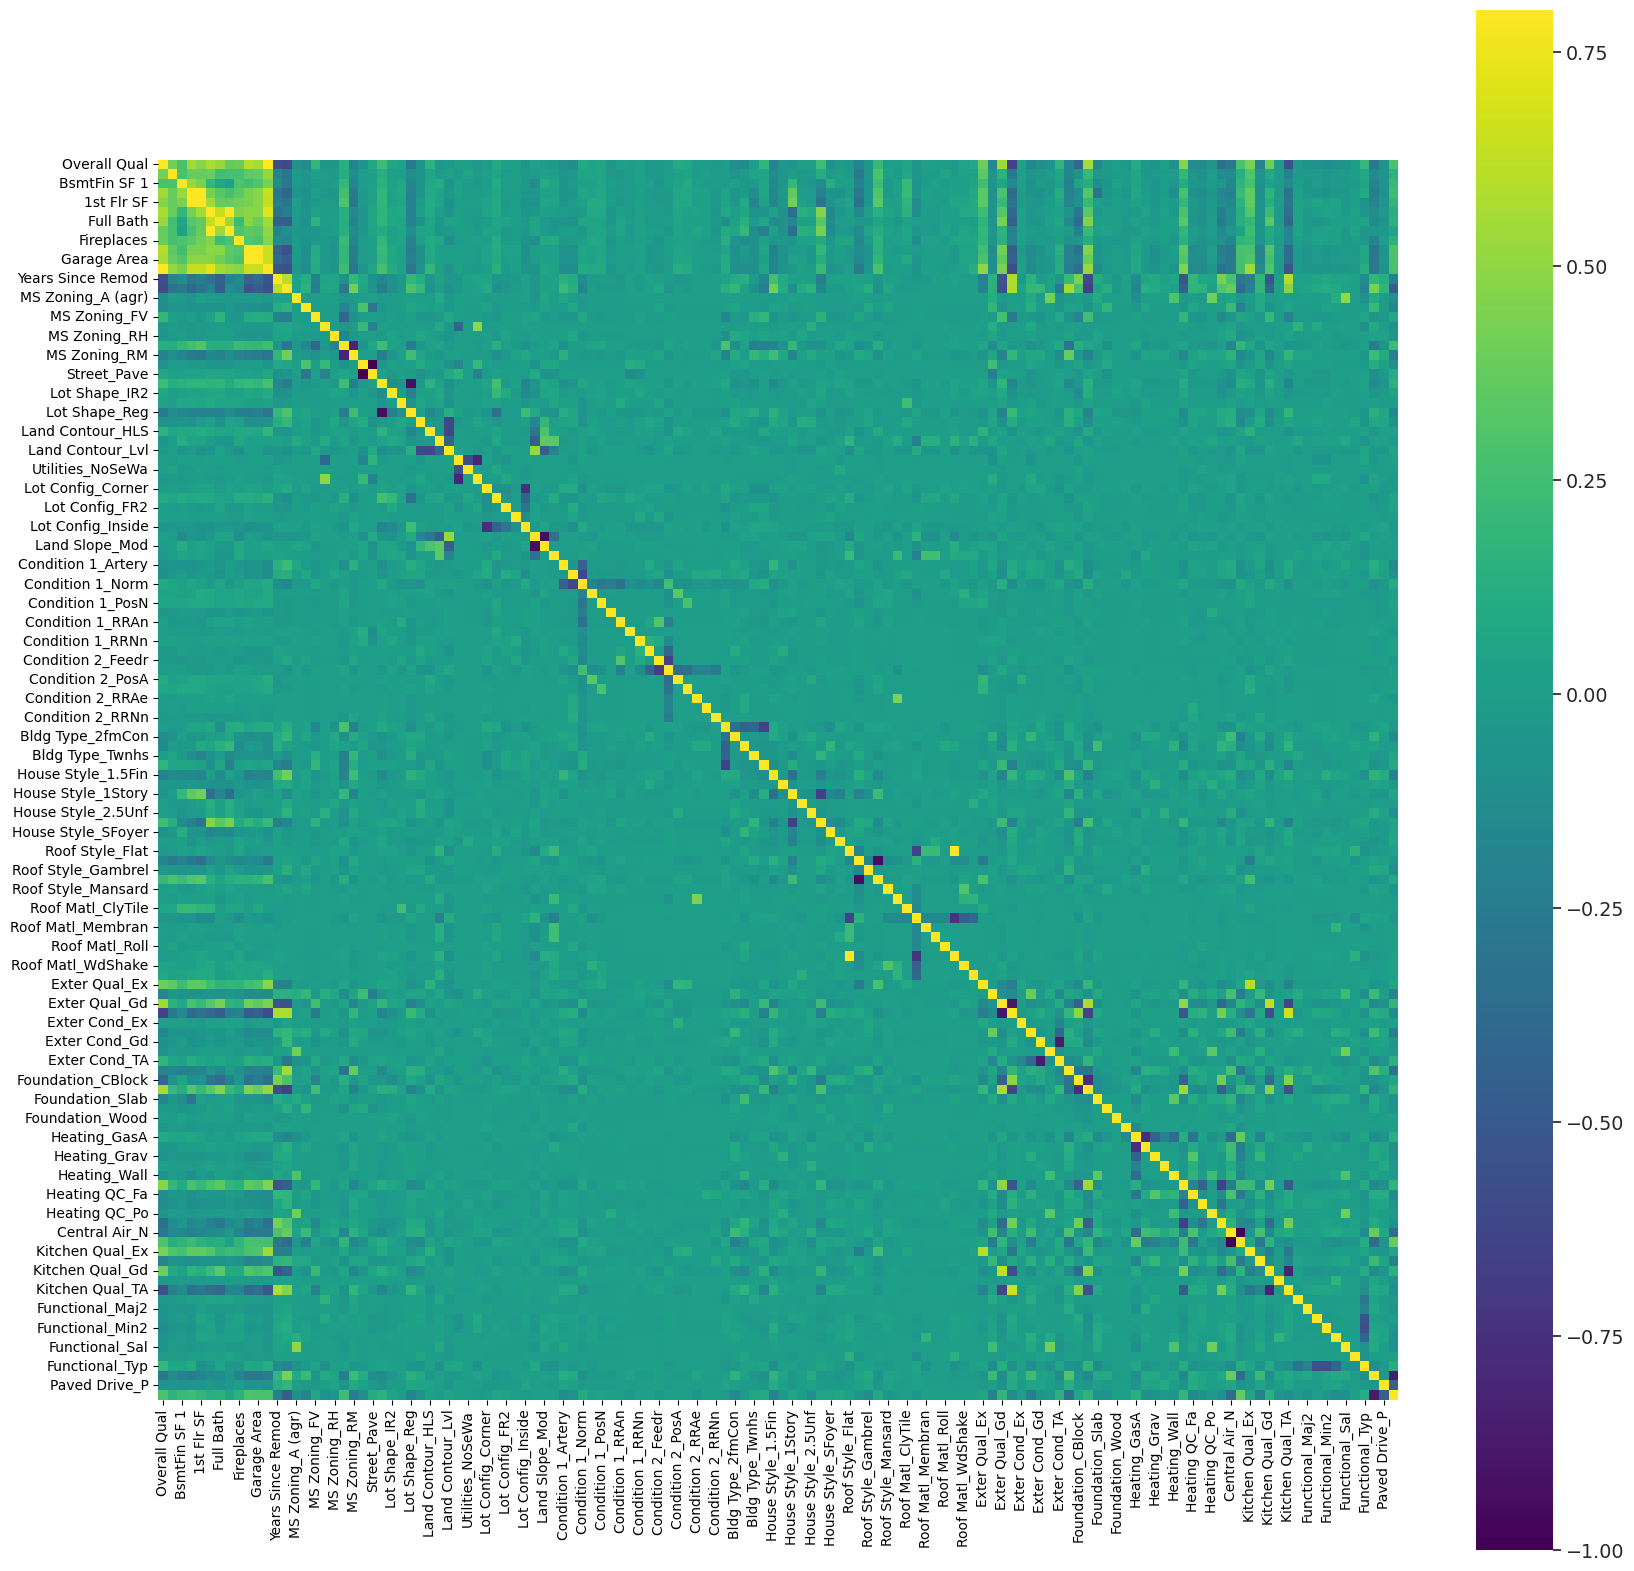

In [6]:
corrmat = filtered_df.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, annot = False, vmax=0.8, square=True, annot_kws={'size': 10},cmap = 'viridis');


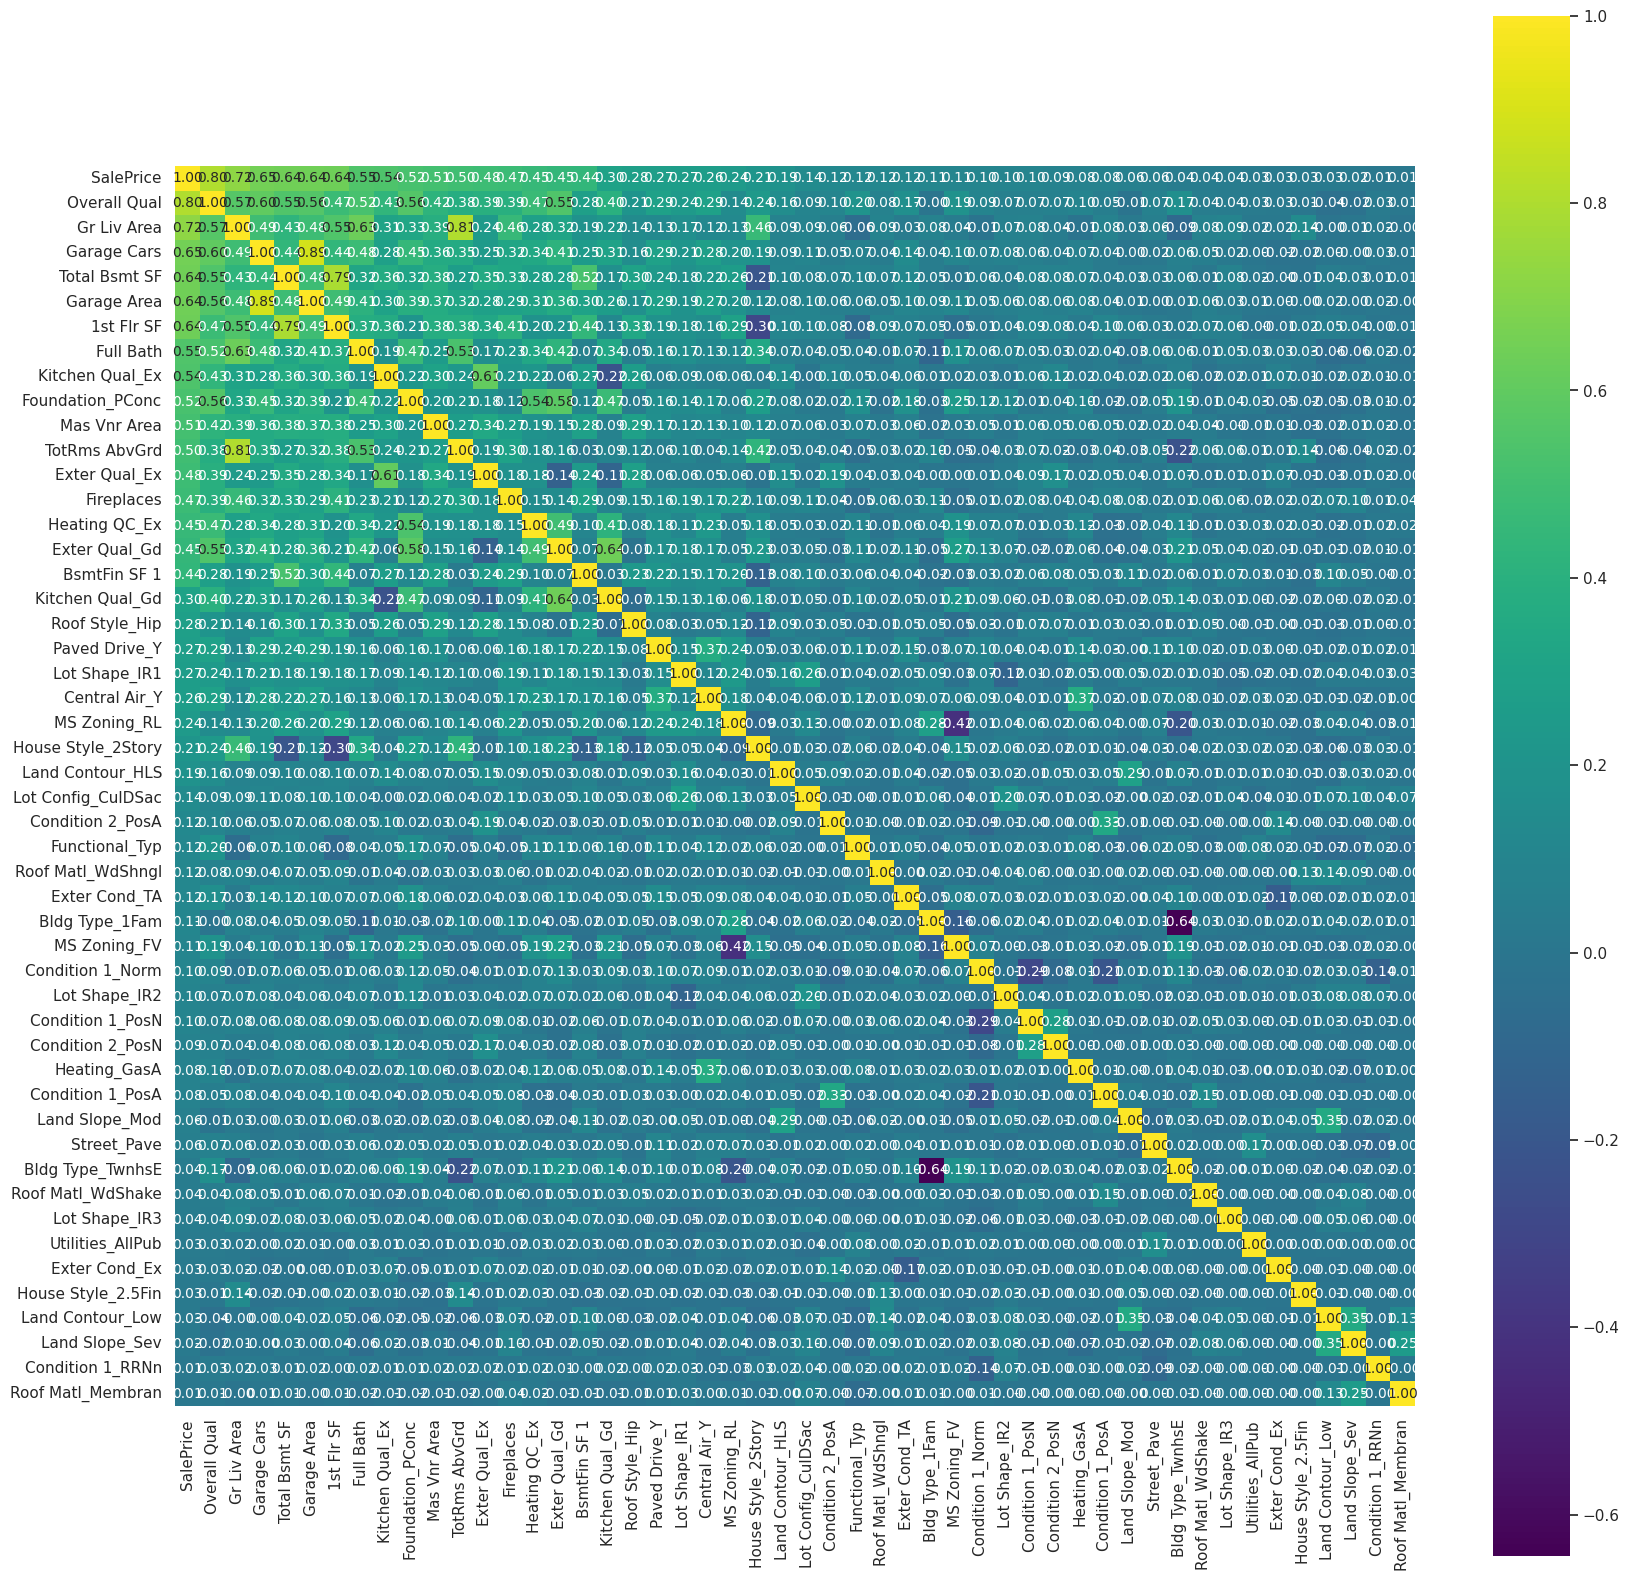

In [7]:
k = 50 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(filtered_df[cols].values.T)
plt.figure(figsize=(20, 20))

sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,cmap = 'viridis')
# plt.show()

In [8]:
key_features =list(filtered_df[cols].keys())
key_data = pd.DataFrame(filtered_df[key_features])


In [9]:
from sklearn.preprocessing import StandardScaler
# Spliting target variable and independent variables
X = key_data.drop(['SalePrice'], axis = 1)
y = key_data['SalePrice']
# Splitting to training and testing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = 0.3, random_state = 4)


In [10]:
from sklearn.preprocessing import StandardScaler
# Spliting target variable and independent variables
X = key_data.drop(['SalePrice'], axis = 1)
y = key_data['SalePrice']
# Splitting to training and testing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = 0.3, random_state = 4)


LINEAR REGRESSION

In [ ]:

print('------------Linear Regression-----------------')
# Import library for Linear Regression
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)

# Model prediction on train data
y_pred = lm.predict(X_train)

# # Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
print('RMSE:',np.sqrt(sum((y_pred - y_train)**2) / len(y_pred)))
# Predicting Test data with the model
y_test_pred = lm.predict(X_test)
#Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
mae_linreg = metrics.mean_absolute_error(y_test, y_test_pred)
rmse_linreg = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
rmse_linreg2 =  (rmse_linreg / (sum(y_test_pred)/len(y_test_pred)))
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',mae_linreg)
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',rmse_linreg)
print('RMSE (Linear Regression): {:.2f}'.format(rmse_linreg2))


------------Linear Regression-----------------
R^2: 0.8744734714966333
Adjusted R^2: 0.8713949930698741
MAE: 17881.590118859305
MSE: 761516090.0902853
RMSE: 27595.5809884533
RMSE: 27595.580988453297
R^2: 0.8779434447319371
Adjusted R^2: 0.870729004191364
MAE: 19640.669600394467
MSE: 869390299.5955682
RMSE: 29485.425206287397
RMSE (Linear Regression): 0.16


<ipython-input-20-5fdecff6b157>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test, y_test_pred, alpha=0.7, cmap=palette, edgecolors='k', s=50)  # Added edgecolors and marker size


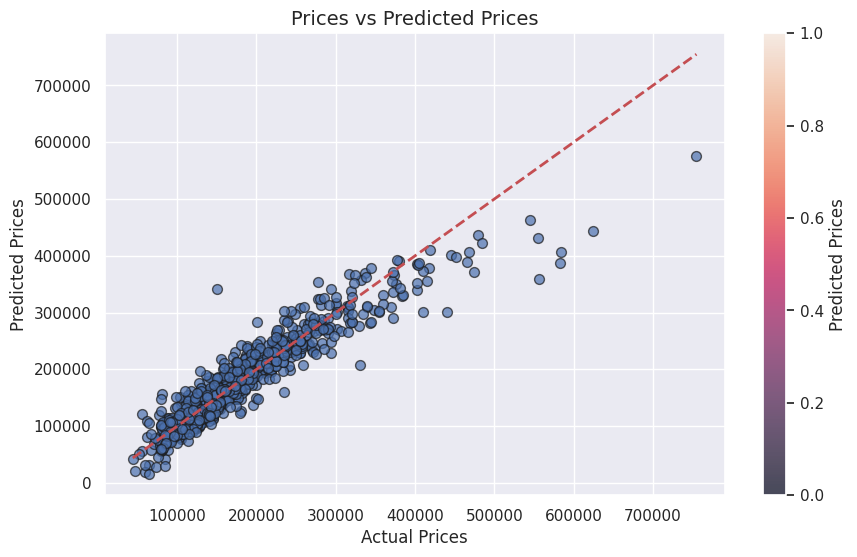

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualizing the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))  # Adjusted figure size to match the original
plt.scatter(y_test, y_test_pred, alpha=0.7, cmap=palette, edgecolors='k', s=50)  # Added edgecolors and marker size
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted Prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.grid(True)
plt.show()


# XG BOOST

In [ ]:
print('------------XGBoost Regressor-----------------')
# Import XGBoost Regressor
from xgboost import XGBRegressor

#Create a XGBoost Regressor
reg = XGBRegressor()

# Train the model using the training sets
reg.fit(X_train, y_train)

# Model prediction on train data
y_pred = reg.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

#Predicting Test data with the model
y_test_pred = reg.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation
acc_xgb = metrics.r2_score(y_test, y_test_pred)
mae_xgb = metrics.mean_absolute_error(y_test, y_test_pred)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
rmse_xgb2 =  (rmse_xgb / (sum(y_test)/len(y_test)))
print('R^2:', acc_xgb)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',mae_xgb)
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',rmse_xgb)
print('RMSE (XG Boost): {:.2f}'.format(rmse_xgb2))

------------XGBoost Regressor-----------------
------------Train Set-----------------
R^2: 0.9960986741944672
Adjusted R^2: 0.9960029960340713
MAE: 3441.6212391853333
MSE: 23667685.301422298
RMSE: 4864.944532204072
------------Test Set-----------------
R^2: 0.8909185672866671
Adjusted R^2: 0.8844710519634423
MAE: 17859.035320676907
MSE: 776970472.8982506
RMSE: 27874.19008506347
RMSE (XG Boost): 0.15


<ipython-input-28-5fdecff6b157>:9: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



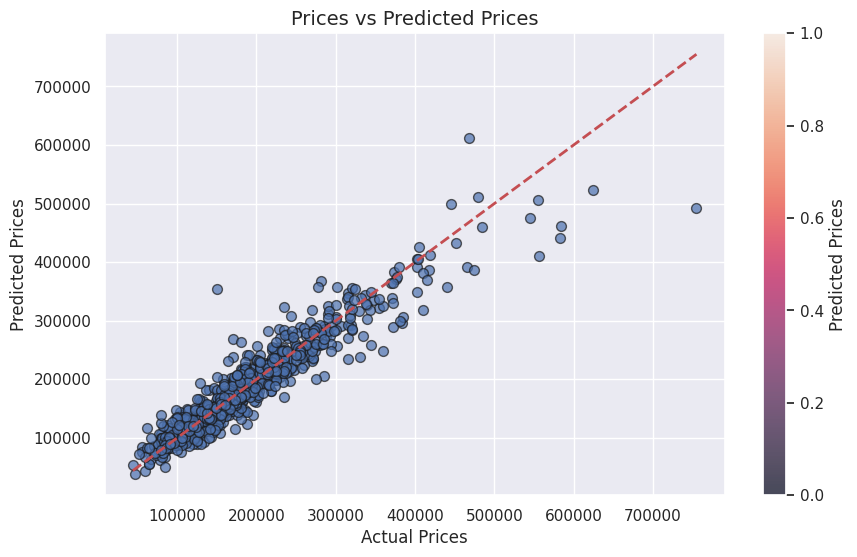

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualizing the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))  # Adjusted figure size to match the original
plt.scatter(y_test, y_test_pred, alpha=0.7, cmap=palette, edgecolors='k', s=50)  # Added edgecolors and marker size
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted Prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.grid(True)
plt.show()


# XG BOOST HYPERPARAMETER TUNING

In [ ]:
print('------------XGBoost Regressor-----------------')

# Import XGBoost Regressor
from xgboost import XGBRegressor

# Define the hyperparameters to iterate over
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.001, 0.0001],
    'n_estimators': [100, 500, 1000],
    'missing': [np.nan],
    'objective': ['reg:squarederror'],
    'reg_lambda': [0, 1, 10],
}


# create XGBoost regressor
model = XGBRegressor(
    tree_method='gpu_hist',
    verbosity=0,
    # reg_lambda=1
)

# perform grid search using 5-fold cross-validation
grid_search = GridSearchCV( estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error',cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
# fit the model to the training data

# get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
y_pred = best_model.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
# print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

# make predictions on the test data
y_pred_xgt = best_model.predict(X_test)

# evaluate the model on the test data
acc_xgb = metrics.r2_score(y_test, y_pred_xgt)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_xgt)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgt))
rmse_xgb2 = (rmse_xgb / (sum(y_test) / len(y_test)))

# print the results
print('------------Test Set-----------------')
print('R^2:', acc_xgb)
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_test, y_pred_xgt)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print('MAE:', mae_xgb)
print('MSE:', metrics.mean_squared_error(y_test, y_pred_xgt))
print('RMSE:', rmse_xgb)
print('RMSE (XG Boost): {:.2f}'.format(rmse_xgb2))
print("Best Hyperparameters:", best_params)

------------XGBoost Regressor-----------------
------------Train Set-----------------
R^2: 0.944135798360607
Adjusted R^2: 0.9427657553774588
MAE: 13184.834526062012
MSE: 338904364.8036907
------------Test Set-----------------
R^2: 0.9076133028741996
Adjusted R^2: 0.9021525692684527
MAE: 17286.297150526167
MSE: 658056407.6746558
RMSE: 25652.6101532506
RMSE (XG Boost): 0.14
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'missing': nan, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'reg_lambda': 1}


<ipython-input-35-98bf892fe6a6>:9: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



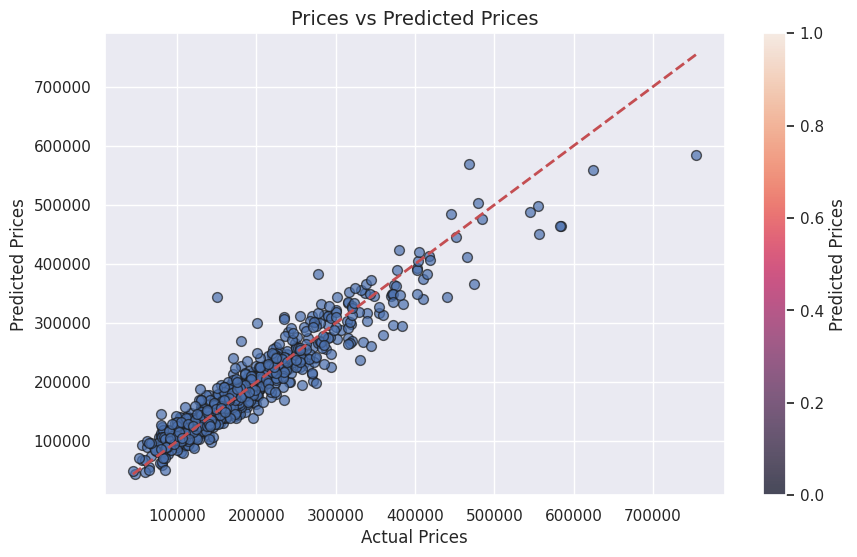

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualizing the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))  # Adjusted figure size to match the original
plt.scatter(y_test, y_pred_xgt, alpha=0.7, cmap=palette, edgecolors='k', s=50)  # Added edgecolors and marker size
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted Prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualizing the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))  # Adjusted figure size to match the original
plt.scatter(y_test, y_test_pred, alpha=0.7, cmap=palette, edgecolors='k', s=50)  # Added edgecolors and marker size
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted Prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.grid(True)
plt.show()


# RANDOM FORREST

In [ ]:
print('------------Random Forest Regressor-----------------')

# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg_rf = RandomForestRegressor(random_state=4)

# Train the model using the training sets
#Fit the model to the training data

reg_rf.fit(X_train, y_train)

# Model prediction on train data
y_pred_rf_train = reg_rf.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_pred_rf_train))
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_train, y_pred_rf_train)) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_rf_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_rf_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_rf_train)))

# Predicting Test data with the model
y_pred_rf_test = reg_rf.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation for test set
acc_rf = metrics.r2_score(y_test, y_pred_rf_test)
mae_rf = metrics.mean_absolute_error(y_test, y_pred_rf_test)
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_test))
rmse_rf2 =  (rmse_rf / (sum(y_pred_rf_test)/len(y_pred_rf_test)))
print('R^2:', acc_rf)
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_test, y_pred_rf_test)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print('MAE:', mae_rf)
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf_test))
print('RMSE:', rmse_rf)
print('RMSE:', rmse_rf2)


------------Random Forest Regressor-----------------
------------Train Set-----------------
R^2: 0.9819198676557807
Adjusted R^2: 0.9814764610066982
MAE: 6379.029184163412
MSE: 109684477.49844041
RMSE: 10473.035734611069
------------Test Set-----------------
R^2: 0.8815322878559881
Adjusted R^2: 0.8745299743516979
MAE: 18156.359256731135
MSE: 843827515.2619625
RMSE: 29048.70935621689
RMSE: 0.16060444877496735


<ipython-input-39-4a9a32c304ba>:9: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



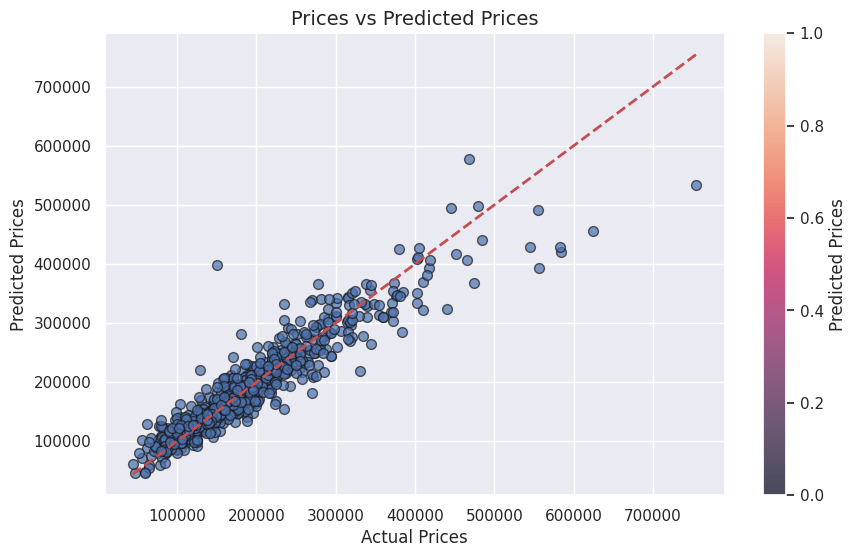

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualizing the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))  # Adjusted figure size to match the original
plt.scatter(y_test, y_pred_rf_test, alpha=0.7, cmap=palette, edgecolors='k', s=50)  # Added edgecolors and marker size
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted Prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.grid(True)
plt.show()

# RANDOM FOREST HYPERPARAMTER TUNING

In [ ]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np

print('------------Random Forest Regressor-----------------')

# Define the hyperparameters to iterate over
param_grid = {
    'n_estimators': [50, 80, 100,500],
    'max_depth': [3, 5, 7,12],
    'min_samples_leaf': [1, 2, 4,6,8,12],
    'bootstrap': [True, False]
}

# Create a Random Forest Regressor
reg_rf = RandomForestRegressor(random_state=4)

# Create a grid search object
grid_search = GridSearchCV(estimator=reg_rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

# # Train the model using the grid search object
# grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Model prediction on train data using the best model
y_pred_rf_train = best_rf_model.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_pred_rf_train))
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_train, y_pred_rf_train)) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_rf_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_rf_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_rf_train)))

# Predicting Test data with the best model
y_pred_rf_test_tuned = best_rf_model.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation for  l.;/'
acc_rf = metrics.r2_score(y_test, y_pred_rf_test)
mae_rf = metrics.mean_absolute_error(y_test, y_pred_rf_test)
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_test))
rmse_rf2 = (rmse_rf / (sum(y_pred_rf_test) / len(y_pred_rf_test)))
print('R^2:', acc_rf)
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_test, y_pred_rf_test)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print('MAE:', mae_rf)
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf_test))
print('RMSE:', rmse_rf)
print('RMSE (Normalized):', rmse_rf2)

# Print the best hyperparameters and the corresponding evaluation metrics
print("Best Hyperparameters:", best_params)

------------Random Forest Regressor-----------------
------------Train Set-----------------
R^2: 0.9689730245759809
Adjusted R^2: 0.9682121027562727
MAE: 8451.5131394501
MSE: 188227471.0687368
RMSE: 13719.601709551804
------------Test Set-----------------
R^2: 0.8815322878559881
Adjusted R^2: 0.8745299743516979
MAE: 18156.359256731135
MSE: 843827515.2619625
RMSE: 29048.70935621689
RMSE (Normalized): 0.16060444877496735
Best Hyperparameters: {'bootstrap': True, 'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 500}


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set style
# palette = sns.color_palette('coolwarm', as_cmap=True)

# # Visualizing the differences between actual prices and predicted values
# plt.figure(figsize=(10, 6))  # Adjusted figure size to match the original
# plt.scatter(y_test, y_pred_rf_test_tuned, alpha=0.7, cmap=palette, edgecolors='k', s=50)  # Added edgecolors and marker size
# plt.xlabel("Actual Prices", fontsize=12)
# plt.ylabel("Predicted Prices", fontsize=12)
# plt.title("Prices vs Predicted Prices", fontsize=14)
# plt.colorbar(label="Predicted Prices")
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
# plt.grid(True)
# plt.show()

# SVR

In [11]:
print('------------SVR-----------------')
# Import SVR
from sklearn.svm import SVR

# Create an SVR model
svr_regressor = SVR(kernel='rbf')  # 'rbf' kernel is commonly used

# Train the model using the training sets
svr_regressor.fit(X_train, y_train)

# Model prediction on train data
y_train_SVR_pred = svr_regressor.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_train_SVR_pred))
print('MAE:', metrics.mean_absolute_error(y_train, y_train_SVR_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_train_SVR_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_train_SVR_pred)))

# Predicting Test data with the model
y_test_SVR_pred = svr_regressor.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation for test set
acc_svr = metrics.r2_score(y_test, y_test_SVR_pred)
mae_svr = metrics.mean_absolute_error(y_test, y_test_SVR_pred)
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test, y_test_SVR_pred))
rmse_svr2 = (rmse_svr / (sum(y_test) / len(y_test)))

print('R^2:', acc_svr)
print('MAE:', mae_svr)
print('MSE:', metrics.mean_squared_error(y_test, y_test_SVR_pred))
print('RMSE:', rmse_svr)
print('RMSE (SVR): {:.2f}'.format(rmse_svr2))


------------SVR-----------------
------------Train Set-----------------
R^2: -0.0658457047515808
MAE: 54963.42219489279
MSE: 6466032825.086687
RMSE: 80411.64607870359
------------Test Set-----------------
R^2: -0.06303952370240062
MAE: 58323.17456815664
MSE: 7571869023.862115
RMSE: 87016.4870806798
RMSE (SVR): 0.48


# SVR TUNED

In [12]:
print('------------SVR-----------------')

# Import SVR
from sklearn.svm import SVR

# Define the hyperparameters to iterate over
param_grid = {
    'kernel': ['linear', 'rbf','poly'],
    'C': [0.1, 1, 10, 20, 50, 100, 200, 500, 1000],
    'gamma': [0.01, 0.001, 0.001]
}

# Create SVR regressor
model = SVR()

# Perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the model to the training data
# for i in tqdm.tqdm(range(100), desc="Training model...", total=100):


grid_search.fit(X_train, y_train)


# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Model prediction on train data
y_train_SVR_pred = best_model.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_train_SVR_pred))
print('MAE:', metrics.mean_absolute_error(y_train, y_train_SVR_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_train_SVR_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_train_SVR_pred)))

# Predicting Test data with the model
y_test_SVR_pred = best_model.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation for test set
acc_svr = metrics.r2_score(y_test, y_test_SVR_pred)
mae_svr = metrics.mean_absolute_error(y_test, y_test_SVR_pred)
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test, y_test_SVR_pred))
rmse_svr2 = (rmse_svr / (sum(y_test) / len(y_test)))

# Print the results
print('R^2:', acc_svr)
print('MAE:', mae_svr)
print('MSE:', metrics.mean_squared_error(y_test, y_test_SVR_pred))
print('RMSE:', rmse_svr)
print('RMSE (SVR): {:.2f}'.format(rmse_svr2))
print("Best Hyperparameters:", best_params)


------------SVR-----------------
------------Train Set-----------------
R^2: 0.8651543636381487
MAE: 17092.25651117698
MSE: 818051156.1367629
RMSE: 28601.59359435699
------------Test Set-----------------
R^2: 0.8787034773037927
MAE: 18997.169479818123
MSE: 863976703.0550394
RMSE: 29393.48062164533
RMSE (SVR): 0.16
Best Hyperparameters: {'C': 1000, 'gamma': 0.01, 'kernel': 'linear'}


# FINAL RESULTS

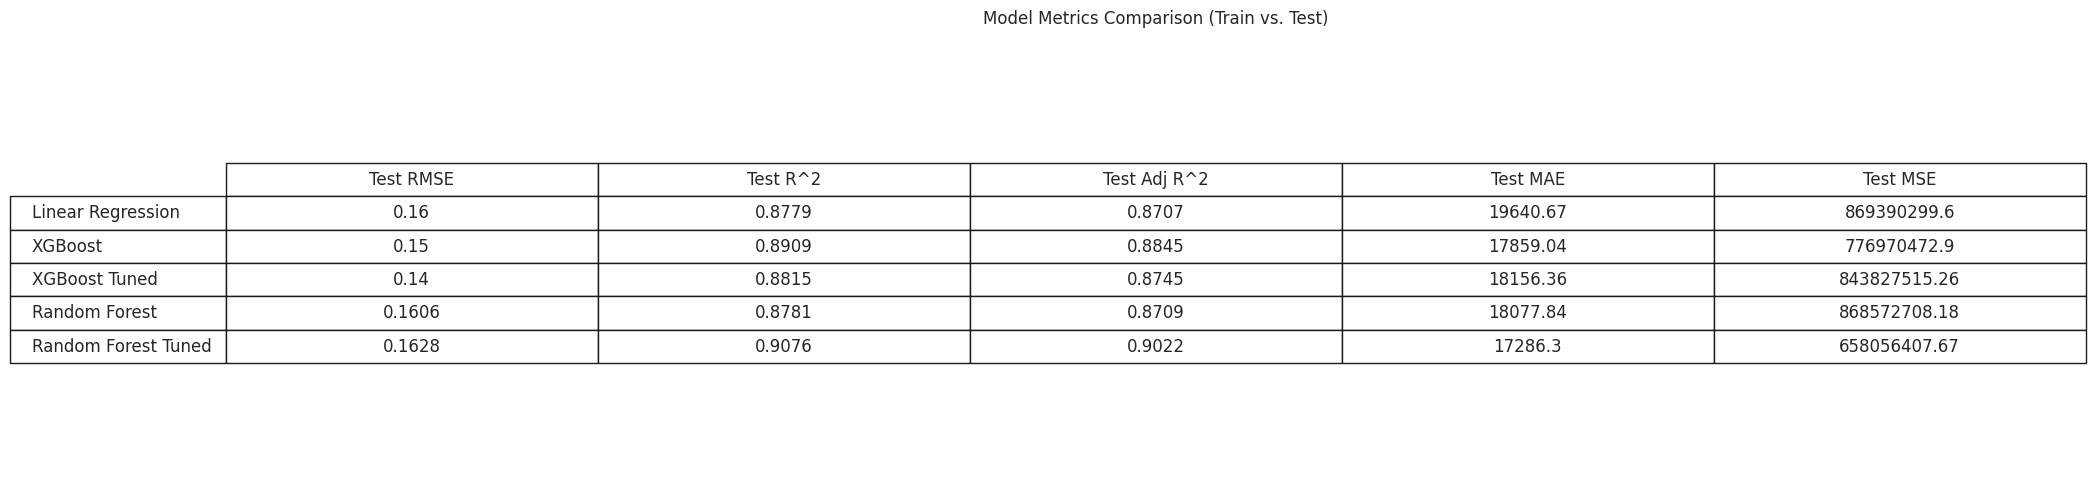

In [ ]:
import matplotlib.pyplot as plt

# Define the data
models = ['Linear Regression', 'XGBoost', 'XGBoost Tuned', 'Random Forest', 'Random Forest Tuned',]
train_r2 = [0.8745, 0.9961, 0.9076, 0.9819, 0.8781]
test_r2 = [0.8779, 0.8909, 0.8815, 0.8781, 0.9076]

train_adj_r2 = [0.8714, 0.9960, 0.9022, 0.9815, 0.8709]
test_adj_r2 = [0.8707, 0.8845, 0.8745, 0.8709, 0.9022]

train_mae = [17881.59, 3441.62, 17286.30, 6379.03, 8451.51]
test_mae = [19640.67, 17859.04, 18156.36, 18077.84, 17286.30]

train_mse = [761516090.09, 23667685.30, 658056407.67, 109684477.50, 188227471.07]
test_mse = [869390299.60, 776970472.90, 843827515.26, 868572708.18, 658056407.67]

test_rmse_normalized = [0.16, 0.15, 0.14, 0.1606, 0.1628]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create the table
cell_text = [ test_rmse_normalized,test_r2, test_adj_r2, test_mae,  test_mse]
rows = [ "Test RMSE",'Test R^2','Test Adj R^2',  'Test MAE', 'Test MSE']
cell_text = list(map(list, zip(*cell_text)))  # Transpose cell_text for the table

table = ax.table(cellText=cell_text, rowLabels=models, colLabels=rows, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2, 2)

# Hide axis
ax.axis('off')

# Show the table
plt.title('Model Metrics Comparison (Train vs. Test)')
plt.show()
